# FGSM Imagenewoof Dataset Development W/ConvNeXtTiny Usage

In this notebook, we explore the Fast Gradient Sign Method (FGSM) applied to the Imagenewoof dataset, a subset of the ImageNet dataset focusing specifically on dog breeds. The FGSM is a well-known technique in adversarial machine learning used to craft adversarial examples by perturbing input data slightly to deceive machine learning models. In this context, we leverage ConvNeXtTiny, a convolutional neural network architecture, to examine how FGSM affects the classification performance on the Imagenewoof dataset. Throughout this notebook, we will delve into dataset development, implementation of FGSM, and the evaluation of ConvNeXtTiny under adversarial attacks, providing insights into the robustness and vulnerabilities of deep learning models in image classification tasks.

In [1]:
# Tensorflow logging: OFF
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [2]:
# TensorFlow
import tensorflow as tf

# Layers, models, optimizers, losses, and callbacks
from tensorflow.keras import Input, layers, models, optimizers, callbacks, losses

# ConvNeXtTiny
from tensorflow.keras.applications.convnext import ConvNeXtTiny

# Other libraries
import numpy as np
import matplotlib.pyplot as mpl
import pathlib
import pickle

print(f'Tensorflow Version: {tf.__version__}')

Tensorflow Version: 2.15.0


In [3]:
# Check GPU availability
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)
else:
    print("No GPUs detected.")

1 Physical GPUs, 1 Logical GPUs


## Global constants and parameters

In [4]:
# Image and batch size
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Various epochs size
EPOCHS = 10
FINE_TUNE_EPOCHS = 10
TOTAL_EPOCHS = EPOCHS + FINE_TUNE_EPOCHS

# Patience for both ReduceOnPlateau and EarlyStopping
REDUCELR_PATIENCE, EARLY_STOP_PATIENCE = 3, 3

In [5]:
# Plot configurations for later observations
mpl.rcParams['figure.figsize'] = (5, 5)
mpl.rcParams['axes.grid'] = False

## Loading Imagenewoof dataset

Loading the dataset we will get two `keras.utils` datasets:

- The `train_dataset` corresponding to the training dataset.
- The `validation_dataset` corresponding to the validation dataset.

The images are 320x320, with pixel values ranging from 0 to 255. The labels are an array of strings, ranging from 0 to 4. These correspond to the class of clothing the image represents:

| <div style="width:300px">**Label**</div> |  <div style="width:300px">**Class**</div>  |
|:---------------|:---------------|
| n02086240      | Shih-Tzu |
| n02087394      | Rhodesian ridgeback |
| n02088364      | Beagle |
| n02089973      | English foxhound |
| n02093754      | Border terrier |

<br>

In [6]:
# Load ImageWoof dataset using tf.keras.utils.image_dataset_from_directory
train_dataset = tf.keras.utils.image_dataset_from_directory(
    'Datasets/Imagewoof/Train',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='int'
)

Found 4344 files belonging to 5 classes.


In [7]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(
    'Datasets/Imagewoof/Val',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='int'
)

Found 1860 files belonging to 5 classes.


#### Define new classes with the correct dog breeds

In [8]:
dog_breeds = ['Shih-Tzu', 'Rhodesian ridgeback', 'Beagle', 'English foxhound', 'Border terrier']
print(dog_breeds)

['Shih-Tzu', 'Rhodesian ridgeback', 'Beagle', 'English foxhound', 'Border terrier']


#### Exploring the data

In [9]:
# Class names by default
class_names = train_dataset.class_names
print(class_names)

['n02086240', 'n02087394', 'n02088364', 'n02089973', 'n02093754']


In [10]:
# Change alpha-numeric classes to dog breed names
class_names = dog_breeds
print(f'New class names: {class_names}')

New class names: ['Shih-Tzu', 'Rhodesian ridgeback', 'Beagle', 'English foxhound', 'Border terrier']


In [11]:
# Check the shape and batch of the image and label
for image_batch, labels_batch in train_dataset:
    print(f'IMG_BATCH SHAPE: {image_batch.shape}')
    print(f'LBS_BATCH SHAPE: {labels_batch.shape}')
    break

IMG_BATCH SHAPE: (32, 224, 224, 3)
LBS_BATCH SHAPE: (32,)


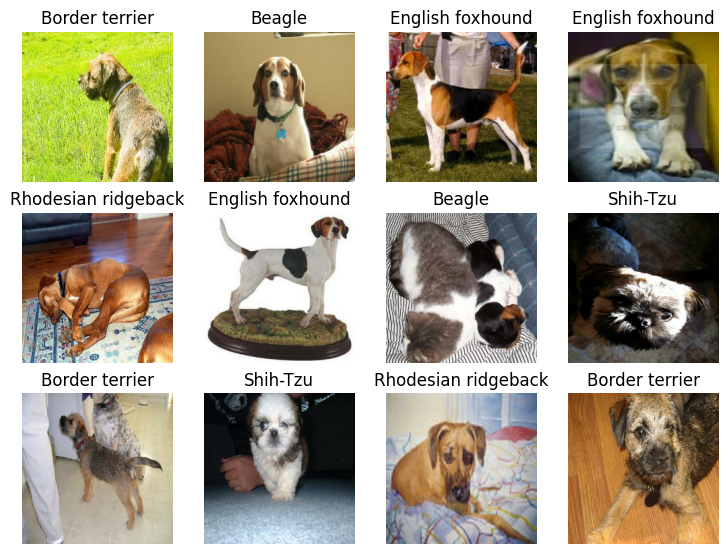

In [12]:
mpl.figure(figsize=(9, 9))
for images, labels in train_dataset.take(1):
  for i in range(12):
    ax = mpl.subplot(4, 4, i + 1)
    mpl.imshow(images[i].numpy().astype("uint8"))
    mpl.title(class_names[labels[i]])
    mpl.axis("off")

In [13]:
# Understand what is the range of the dataset
for images, labels in train_dataset.take(1):
    data_type = images[0].dtype
    max_value = tf.reduce_max(images[0]).numpy()
    
    if data_type == tf.uint8:
        print("[INFO] Images are in the range [0, 255]")
    elif data_type == tf.float32:
        if max_value <= 1.0:
            print("[INFO] Images are in the range [0, 1]")
        else:
            print("[INFO] Images are in the range [0, 255] (but represented as float32)")
    else:
        print("[INFO] Images might have a different data type or preprocessing")

[INFO] Images are in the range [0, 255] (but represented as float32)


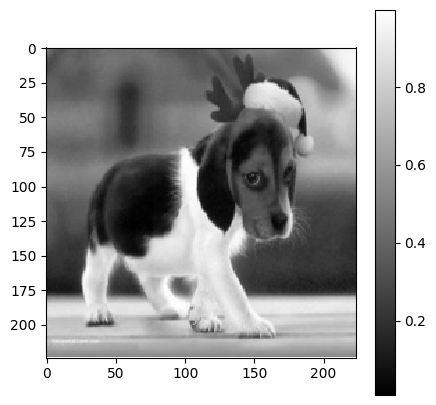

In [14]:
# Plot for image visualisation
for images, labels in train_dataset.take(1):
    images = images / 255.0
    index_to_visualize = 0
    gray_image = tf.image.rgb_to_grayscale(images[index_to_visualize])
    gray_image_np = gray_image.numpy()
    mpl.figure()
    mpl.imshow(gray_image_np[:, :, 0], cmap='gray', interpolation='nearest')
    mpl.colorbar()
    mpl.grid(False)
    mpl.show()

## Data preprocessing

As the original dataset doesn't contain a test set, we need create one. To do so, determine how many batches of data are available in the validation set using tf.data.experimental.cardinality, then move 20% of them to a test set.

In [15]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [16]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 48
Number of test batches: 11


#### Configure the dataset for performance

Use buffered prefetching to load images from disk without having I/O become blocking.

In [17]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

#### Use data augmentation

It's a good practice to artificially introduce sample diversity by applying random, yet realistic, transformations to the training images, such as rotation and horizontal flipping. This helps expose the model to different aspects of the training data and reduce overfitting. 

In [18]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(height_factor=0.2, width_factor=0.2),
    # tf.keras.layers.RandomContrast(factor=0.2), # Error with the FGSM gradient development later...
    tf.keras.layers.RandomBrightness(factor=0.2)
])

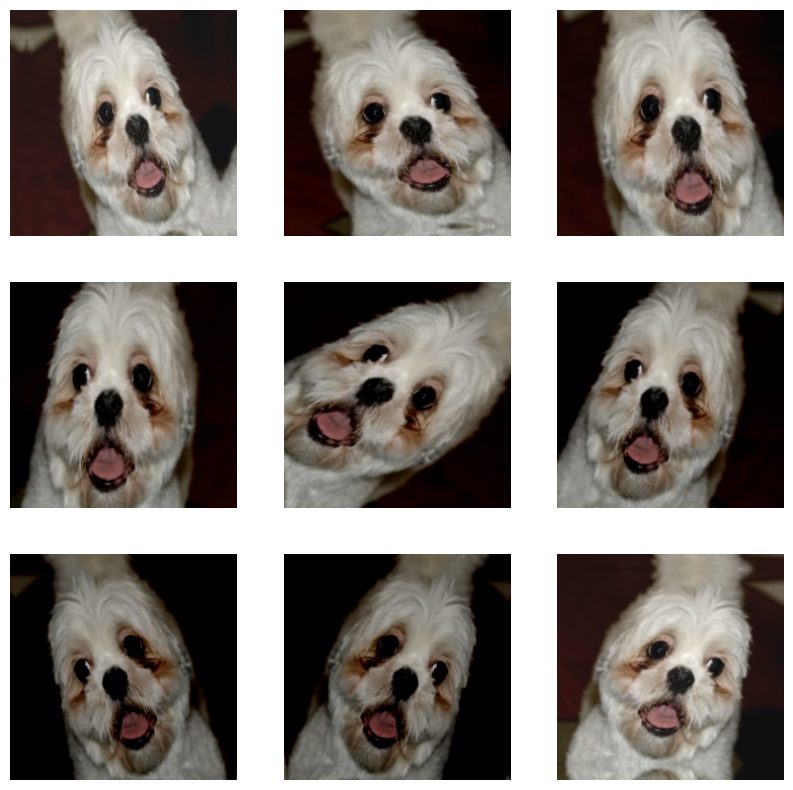

In [19]:
for image, _ in train_dataset.take(1):
    mpl.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = mpl.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        mpl.imshow(augmented_image[0] / 255)
        mpl.axis('off')

## Create the base model from the pre-trained convnets

By specifying the `include_top=False` argument, we load a network that doesn't include the classification layers at the top, which is ideal for feature extraction.

In [20]:
# Create the base model from the pre-trained model ConvNeXtTiny
base_model = ConvNeXtTiny(
    weights='imagenet', 
    include_top=False,
    input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)
)

This feature extractor converts each 224x224x3 image into a 7x7x768 block of features. Let's see what it does to an example batch of images:

In [21]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

I0000 00:00:1706872895.677736  124511 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


(32, 7, 7, 768)


## Feature extraction

In this step, we will freeze the convolutional base created from the previous step and to use as a feature extractor. Additionally, we'll add a classifier on top of it and train the top-level classifier.

#### Freeze the convolutional base

It is important to freeze the convolutional base before you compile and train the model. Freezing (by setting layer.trainable = False) prevents the weights in a given layer from being updated during training. 

In [22]:
base_model.trainable = False

#### Important note about BatchNormalization layers

When we set `layer.trainable = False`, the `BatchNormalization` layer will run in inference mode, and will not update its mean and variance statistics.

When we unfreeze a model that contains `BatchNormalization` layers in order to do fine-tuning, we should keep the `BatchNormalization` layers in inference mode by passing `training = False` when calling the base model. Otherwise, the updates applied to the non-trainable weights will destroy what the model has learned.

In [23]:
base_model.summary()

Model: "convnext_tiny"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 convnext_tiny_prestem_norm  (None, 224, 224, 3)          0         ['input_1[0][0]']             
 alization (Normalization)                                                                        
                                                                                                  
 convnext_tiny_stem (Sequen  (None, 56, 56, 96)           4896      ['convnext_tiny_prestem_normal
 tial)                                                              ization[0][0]']               
                                                                                      

#### Add a classification head

In [24]:
global_average_layer = layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 768)


In [25]:
prediction_layer = layers.Dense(len(class_names), activation='softmax')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 5)


#### Build the model

In [26]:
# Define input layer with the specified image size and channels
inputs = Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3))

# Apply data augmentation to the input data
augmented_inputs = data_augmentation(inputs)

# Pass the augmented inputs through the base model (pre-trained model) without training
features = base_model(augmented_inputs, training=False)

# Perform global average pooling to reduce spatial dimensions
pooled_features = global_average_layer(features)

# Apply dropout regularization to prevent overfitting
pooled_features = layers.Dropout(0.2)(pooled_features)

# Generate the final predictions using a dense output layer
outputs = prediction_layer(pooled_features)

# Create the model by defining inputs and outputs
model = tf.keras.Model(inputs, outputs)

In [27]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 convnext_tiny (Functional)  (None, 7, 7, 768)         27820128  
                                                                 
 global_average_pooling2d (  (None, 768)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 768)               0         
                                                                 
 dense (Dense)               (None, 5)                 3845      
                                                             

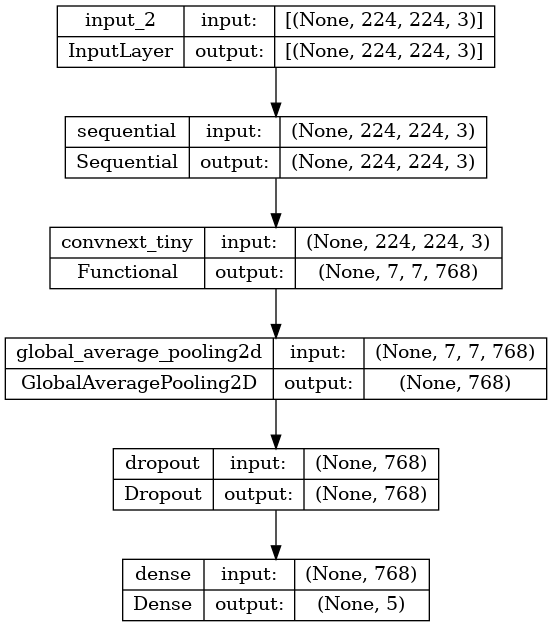

In [28]:
tf.keras.utils.plot_model(model, show_shapes=True)

#### Compile the model

In [29]:
# Compile the model
model.compile(
    optimizer=optimizers.Adam(),
    loss=losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

#### Train the model

In [30]:
# Train the model
history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=validation_dataset
)

Epoch 1/10
136/136 [==============================] - 98s 677ms/step - loss: 0.5048 - accuracy: 0.8531 - val_loss: 0.1220 - val_accuracy: 0.9728
Epoch 2/10
136/136 [==============================] - 82s 601ms/step - loss: 0.2184 - accuracy: 0.9337 - val_loss: 0.0982 - val_accuracy: 0.9755
Epoch 3/10
136/136 [==============================] - 82s 600ms/step - loss: 0.1844 - accuracy: 0.9459 - val_loss: 0.0957 - val_accuracy: 0.9741
Epoch 4/10
136/136 [==============================] - 82s 601ms/step - loss: 0.1598 - accuracy: 0.9523 - val_loss: 0.0985 - val_accuracy: 0.9748
Epoch 5/10
136/136 [==============================] - 82s 601ms/step - loss: 0.1429 - accuracy: 0.9553 - val_loss: 0.0921 - val_accuracy: 0.9755
Epoch 6/10
136/136 [==============================] - 82s 601ms/step - loss: 0.1488 - accuracy: 0.9535 - val_loss: 0.0958 - val_accuracy: 0.9748
Epoch 7/10
136/136 [==============================] - 82s 601ms/step - loss: 0.1464 - accuracy: 0.9503 - val_loss: 0.0955 - val_ac

#### Model evaluation

In [31]:
# Evaluate the model
loss, accuracy = model.evaluate(validation_dataset)
print(f'Pre-Fine tuning validation accuracy: {accuracy * 100:.2f}%')

48/48 [==============================] - 21s 431ms/step - loss: 0.0966 - accuracy: 0.9721
Pre-Fine tuning validation accuracy: 97.21%


#### Learning curves

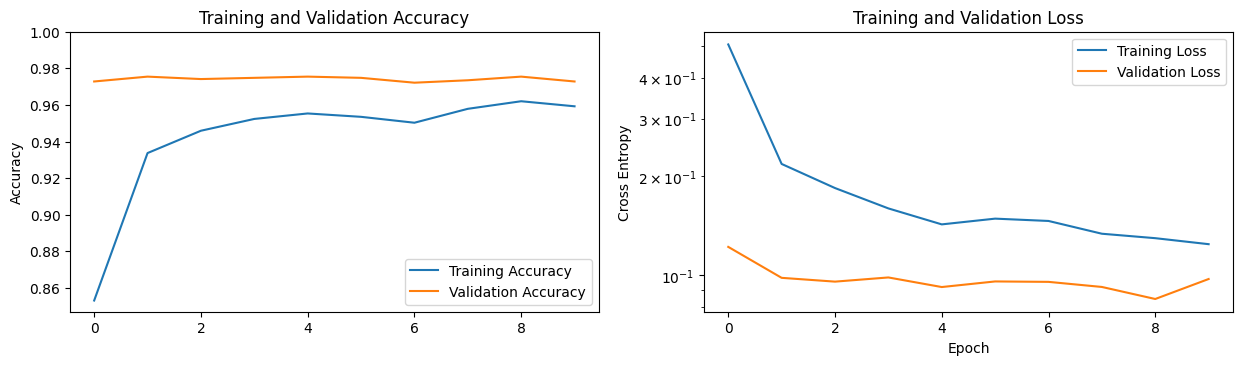

In [32]:
# Accuracy and validation accuracy values
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Loss and validation loss values
loss = history.history['loss']
val_loss = history.history['val_loss']

mpl.figure(1, figsize=(15,8))
mpl.subplot(221)
mpl.plot(acc, label='Training Accuracy')
mpl.plot(val_acc, label='Validation Accuracy')
mpl.legend(loc='lower right')
mpl.ylabel('Accuracy')
mpl.ylim([min(mpl.ylim()),1])
mpl.title('Training and Validation Accuracy')

mpl.subplot(222)
mpl.plot(loss, label='Training Loss')
mpl.plot(val_loss, label='Validation Loss')
mpl.legend(loc='upper right')
mpl.ylabel('Cross Entropy')
mpl.yscale('log')
mpl.title('Training and Validation Loss')
mpl.xlabel('Epoch')

mpl.show()

#### Save the model and history model for later usage

In [33]:
# Save the entire model
model.save('./Models/IWFCX-PREFINETUNING.h5')
print("[INFO] Model saved with success.")

# Save the pickle file of model history
with open('./Models/IWFCX-PREFINETUNING-HISTORY.pkl', 'wb') as history_file:
    pickle.dump(history.history, history_file)
print("[INFO] History model saved with success.")

/home/joseareia/miniconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


[INFO] Model saved with success.
[INFO] History model saved with success.


## Fine tuning

In the feature extraction experiment, we were only training a few layers on top of an ConvNeXtTiny base model. The weights of the pre-trained network were not updated during training.

One way to increase performance even further is to train (or "fine-tune") the weights of the top layers of the pre-trained model alongside the training of the classifier you added. The training process will force the weights to be tuned from generic feature maps to features associated specifically with the dataset.

#### Un-freeze the top layers of the model

In [34]:
base_model.trainable = True

In [35]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

Number of layers in the base model:  151


#### Compile the model... again!

In [36]:
# Compile the model
model.compile(
    optimizer=optimizers.Adam(),
    loss=losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [37]:
# Check the model summary
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 convnext_tiny (Functional)  (None, 7, 7, 768)         27820128  
                                                                 
 global_average_pooling2d (  (None, 768)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 768)               0         
                                                                 
 dense (Dense)               (None, 5)                 3845      
                                                             

#### Continue training the model

In [38]:
# Continue training the previous model
history_finetuning = model.fit(
    train_dataset,
    epochs=TOTAL_EPOCHS,
    initial_epoch=history.epoch[-1],
    validation_data=validation_dataset
)

Epoch 10/20
136/136 [==============================] - 124s 835ms/step - loss: 0.2558 - accuracy: 0.9093 - val_loss: 0.1554 - val_accuracy: 0.9430
Epoch 11/20
136/136 [==============================] - 110s 812ms/step - loss: 0.1465 - accuracy: 0.9457 - val_loss: 0.1926 - val_accuracy: 0.9357
Epoch 12/20
136/136 [==============================] - 110s 812ms/step - loss: 0.1333 - accuracy: 0.9530 - val_loss: 0.3094 - val_accuracy: 0.9085
Epoch 13/20
136/136 [==============================] - 111s 817ms/step - loss: 0.0896 - accuracy: 0.9678 - val_loss: 0.1986 - val_accuracy: 0.9456
Epoch 14/20
136/136 [==============================] - 111s 816ms/step - loss: 0.0919 - accuracy: 0.9685 - val_loss: 0.2169 - val_accuracy: 0.9430
Epoch 15/20
136/136 [==============================] - 110s 813ms/step - loss: 0.0655 - accuracy: 0.9754 - val_loss: 0.2645 - val_accuracy: 0.9344
Epoch 16/20
136/136 [==============================] - 110s 813ms/step - loss: 0.0604 - accuracy: 0.9814 - val_loss: 0

#### Fine tuning learning curves

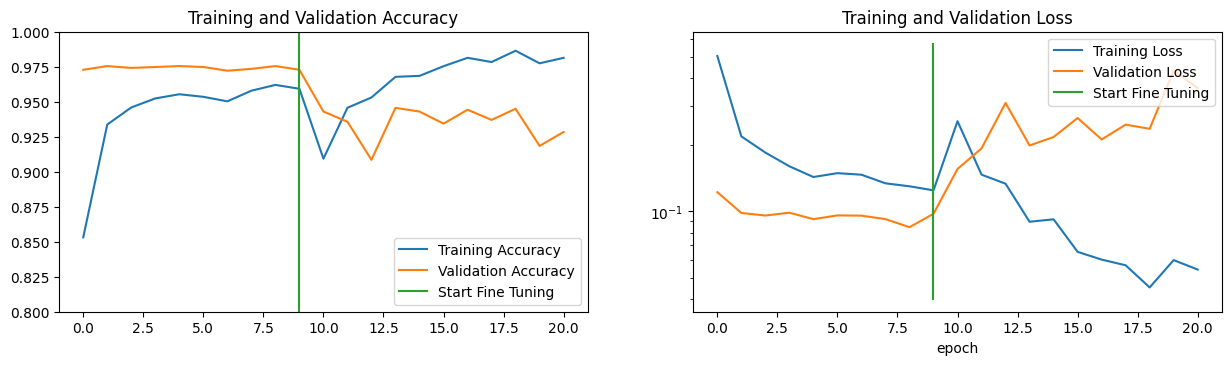

In [39]:
# Accuracy and validation accuracy values
acc += history_finetuning.history['accuracy']
val_acc += history_finetuning.history['val_accuracy']

# Loss and validation loss values
loss += history_finetuning.history['loss']
val_loss += history_finetuning.history['val_loss']

mpl.figure(1, figsize=(15,8))
mpl.subplot(221)
mpl.plot(acc, label='Training Accuracy')
mpl.plot(val_acc, label='Validation Accuracy')
mpl.ylim([0.8, 1])
mpl.plot([EPOCHS-1,EPOCHS-1], mpl.ylim(), label='Start Fine Tuning')
mpl.legend(loc='lower right')
mpl.title('Training and Validation Accuracy')

mpl.subplot(222)
mpl.plot(loss, label='Training Loss')
mpl.plot(val_loss, label='Validation Loss')
mpl.yscale('log')
mpl.plot([EPOCHS-1,EPOCHS-1], mpl.ylim(), label='Start Fine Tuning')
mpl.legend(loc='upper right')
mpl.title('Training and Validation Loss')
mpl.xlabel('epoch')

mpl.show()

#### Evaluation and prediction

In [40]:
loss, accuracy = model.evaluate(test_dataset)
print(f'After fine tuning validation accuracy: {accuracy * 100:.2f}%')

11/11 [==============================] - 5s 443ms/step - loss: 0.2554 - accuracy: 0.9545
After fine tuning validation accuracy: 95.45%


In [41]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)
predictions_index = np.argmax(predictions, axis=1)

print('Predictions:\n', predictions_index)
print('Labels:\n', label_batch)

Predictions:
 [1 2 1 2 2 0 1 0 2 2 0 1 0 4 4 2 2 0 0 0 3 2 0 1 0 1 0 3 1 4 0 0]
Labels:
 [1 2 1 4 2 0 1 0 3 2 0 1 0 4 4 2 2 0 0 0 3 3 0 1 0 1 0 3 1 4 0 0]


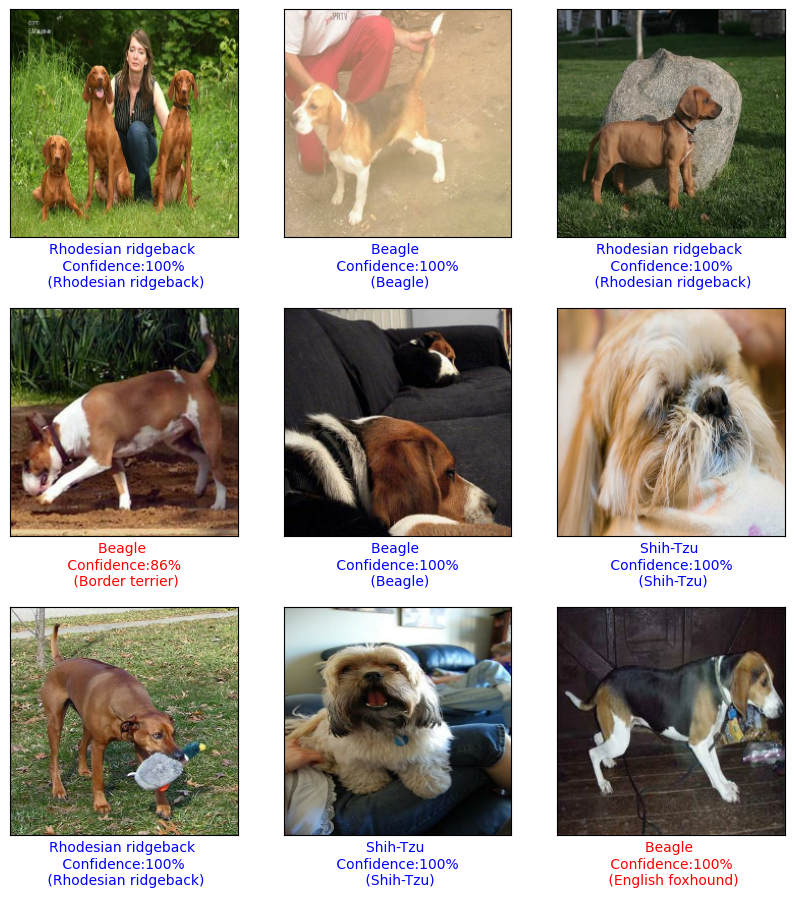

In [42]:
mpl.figure(figsize=(10, 11))
for i in range(9):
    mpl.subplot(3, 3, i + 1)
    mpl.grid(False)
    mpl.xticks([])
    mpl.yticks([])
    mpl.imshow(image_batch[i].astype("uint8"))

    if predictions_index[i] == label_batch[i]:
        color = 'blue'
    else:
        color = 'red'

    mpl.xlabel("{} \n Confidence:{:2.0f}% \n ({})".format(
        class_names[predictions_index[i]],
        100*np.max(predictions[i]),
        class_names[label_batch[i]]),
        color=color
    )

#### Save the model and the history fine tuning model

In [43]:
# Save the pre-trained model
model.save('./Models/IWFCX-FINETUNING.h5')
print("[INFO] Model saved with success.")

# Save the pickle file of model history
with open('./Models/IWFCX-FINETUNING-HISTORY.pkl', 'wb') as history_file:
    pickle.dump(history_finetuning.history, history_file)
print("[INFO] History model saved with success.")

[INFO] Model saved with success.
[INFO] History model saved with success.
